## NBA simulatore

- [x] calendario partite 2021 > NBA21sched  
- [x] PREDITTORE PER TUTTA STAGIONE .. loop , utilizza cfr di PLUS_MINUS_RANK stagione passata per squadra 
- [x] stats medie per squadra > AVG_TEAM_STATS_PRESEASON
- [ ] arricchire criterio .. usare dati stagione corrente + altro 

giocatori on fire 
striscia positiva

- https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md
- https://app.slack.com/client/TGCSU1HDW/CGDKENXGS/thread/CGDKENXGS-1607890992.090800


## LOAD NBA SEASON SCHEDULE 20-21 > NBA21sched

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("NBA2021schedule.csv",sep=";")
df=df.loc[df['Value'].str.startswith('@') == False]
df=df.rename(columns={"Value": "AWAY", "Attribute": "HOME"})
df = df[['GAMEDATE','HOME','AWAY']]
df['AWAY'] = df['AWAY'].apply(lambda x: x.upper())
df['HOME'] = df['HOME'].apply(lambda x: x.upper())
df= df.reset_index()
df['HOME'] = df['HOME'].str.replace('PHO','PHX')
df['AWAY'] = df['AWAY'].str.replace('PHO','PHX')
df['HOME'] = df['HOME'].str.replace('NOR','NOP')
df['AWAY'] = df['AWAY'].str.replace('NOR','NOP')
df['HOME'] = df['HOME'].str.replace('NO','NOP')
df['AWAY'] = df['AWAY'].str.replace('NO','NOP')
df['HOME'] = df['HOME'].str.replace('NY','NYK')
df['AWAY'] = df['AWAY'].str.replace('NY','NYK')
df['HOME'] = df['HOME'].str.replace('SA','SAS')
df['AWAY'] = df['AWAY'].str.replace('SA','SAS')
df['HOME'] = df['HOME'].str.replace('UTH','UTA')
df['AWAY'] = df['AWAY'].str.replace('UTH','UTA')

NBA21sched = df
print(NBA21sched.shape)
NBA21sched.head(1)

NBA21sched.nunique()

(558, 4)


index       558
GAMEDATE     72
HOME         30
AWAY         30
dtype: int64

## PREDICT WIN 
### funz basata su basato SU PLUS_MINUS_RANK di AVG_TEAM_STATS_PRESEASON

In [2]:
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd 

teams = pd.DataFrame(teams.get_teams())
output = leaguedashteamstats.LeagueDashTeamStats(last_n_games='0', measure_type_detailed_defense='Base', month='0', opponent_team_id=0, pace_adjust='N', per_mode_detailed='Totals', period='0', plus_minus='N', rank='N', season='2019-20', season_type_all_star='Regular Season', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', game_scope_simple_nullable='', game_segment_nullable='', league_id_nullable='', location_nullable='', outcome_nullable='', po_round_nullable='', player_experience_nullable='', player_position_abbreviation_nullable='', season_segment_nullable='', shot_clock_range_nullable='', starter_bench_nullable='', team_id_nullable='', two_way_nullable='', vs_conference_nullable='', vs_division_nullable='').get_data_frames()

df = pd.DataFrame(output[0])
AVG_TEAM_STATS_PRESEASON = df

def PREDICT(dfz,TEAM1,TEAM2):
    A = teams.loc[teams['abbreviation'] == TEAM1]['id'].values[0]
    B = teams.loc[teams['abbreviation'] == TEAM2]['id'].values[0]
    A1 = (df.loc[df['TEAM_ID'] == A]['PLUS_MINUS_RANK'].values[0])
    A2 = (df.loc[df['TEAM_ID'] == A]['TEAM_NAME'].values[0])
    B1 = (df.loc[df['TEAM_ID'] == B]['PLUS_MINUS_RANK'].values[0])
    B2 = (df.loc[df['TEAM_ID'] == B]['TEAM_NAME'].values[0])
    if A1<B1:
        win=TEAM1
    else:
        win=TEAM2
    return(win,min(A1,B1),max(A1,B1))

i=0
for index, row in NBA21sched.iterrows():
    TEAM1 = row['HOME'][:3]
    TEAM2 = row['AWAY'][:3]
    OUT = PREDICT(AVG_TEAM_STATS_PRESEASON,TEAM1,TEAM2)
    NBA21sched.at[i, 'PREDICT'] = OUT[0]
    NBA21sched.at[i, 'WIN_RANK'] = OUT[1]
    NBA21sched.at[i, 'LOSE_RANK'] = OUT[2]
    i=i+1

print(NBA21sched.nunique())
NBA21sched

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

NBA21schedP = NBA21sched.groupby(['PREDICT']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

sns.set(rc={'figure.figsize':(14,7)})
ax = sns.barplot(x='PREDICT', y='counts', data=NBA21schedP)
plt.show()


## STAS MEDIE PER GIOCATORE > AVG_PLAYER_STATS_PRESEASON

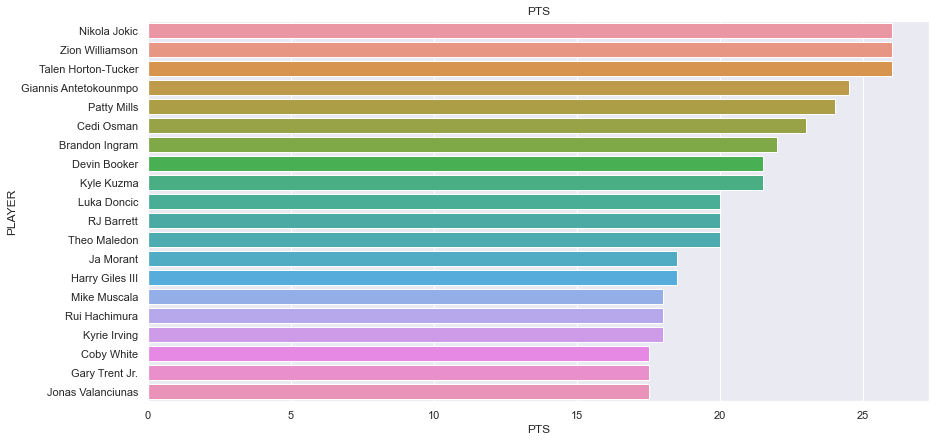

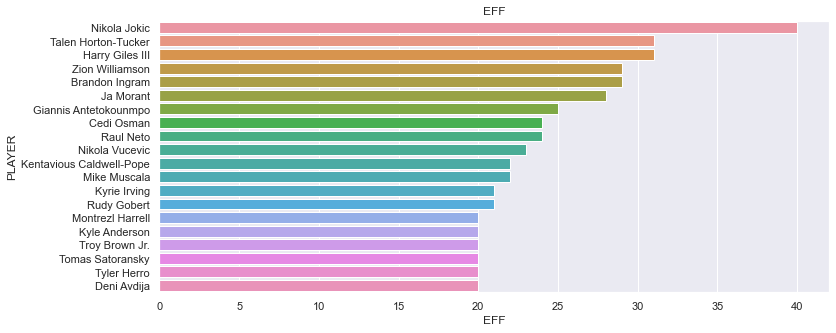

In [12]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

output = leagueleaders.LeagueLeaders(league_id='00', per_mode48='PerGame', scope='RS', season='2020-21', season_type_all_star='Pre Season', stat_category_abbreviation='PTS', active_flag_nullable='').get_data_frames()
AVG_PLAYER_STATS_PRESEASON = pd.DataFrame(output[0])

plt.title('PTS')
toplot = AVG_PLAYER_STATS_PRESEASON.sort_values(by='PTS', ascending=False).head(20)
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.barplot(x='PTS', y='PLAYER', data=toplot)
plt.show()

plt.title('EFF')
toplot = AVG_PLAYER_STATS_PRESEASON.sort_values(by='EFF', ascending=False).head(20)
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.barplot(x='EFF', y='PLAYER', data=toplot)
ax.set_xlabel('EFF')
plt.show()


<div class="alert-warning">
        
# BACKUP GOOD
     
</div>

## Getting Player & Team Ids

In [4]:
from nba_api.stats.static import players
player_dict = players.get_players()

# Use ternary operator or write function 
# Names are case sensitive
bron = [player for player in player_dict if player['full_name'] == 'LeBron James'][0]
bron_id = bron['id']

# find team Ids
from nba_api.stats.static import teams 
teams = teams.get_teams()
GSW = [x for x in teams if x['full_name'] == 'Golden State Warriors'][0]
GSW_id = GSW['id']


## Getting Game Data

In [5]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

gamelog_bron = playergamelog.PlayerGameLog(player_id='2544', season = '2018')
df_bron_games_2018 = gamelog_bron.get_data_frames()
df = pd.DataFrame(df_bron_games_2018[0])
print(df.shape)


(55, 27)


In [6]:
import numpy as np

df["year"] = df["GAME_DATE"].str[-4:]
df.head()

df2 = pd.pivot_table(df,index=["year"],columns=["WL"],values=["PTS"],aggfunc=[np.mean,np.sum,np.max,len])

df3=df2.unstack()
df2.head()

mean          sum      amax     len    
            PTS          PTS       PTS     PTS    
WL            L       W    L    W    L   W   L   W
year                                              
2018  25.642857  28.450  359  569   36  51  14  20
2019  26.769231  28.625  348  229   33  36  13   8

In [7]:
from nba_api.stats.static import teams

import pandas as pd
df = pd.DataFrame(teams.get_teams())
df.head()


,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [8]:
from nba_api.stats.static import players
import pandas as pd

df = pd.DataFrame(players.get_players())
print(df.head())
print(df.shape)

      id            full_name first_name     last_name  is_active
0  76001       Alaa Abdelnaby       Alaa     Abdelnaby      False
1  76002      Zaid Abdul-Aziz       Zaid    Abdul-Aziz      False
2  76003  Kareem Abdul-Jabbar     Kareem  Abdul-Jabbar      False
3     51   Mahmoud Abdul-Rauf    Mahmoud    Abdul-Rauf      False
4   1505    Tariq Abdul-Wahad      Tariq   Abdul-Wahad      False
(4501, 5)


In [9]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

gamelog_bron = playergamelog.PlayerGameLog(player_id='2544', season = '2019')
df_bron_games_2018 = gamelog_bron.get_data_frames()

df = pd.DataFrame(df_bron_games_2018[0])
print(df.shape)
df.head()


(67, 27)


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,2544,0021901310,"AUG 13, 2020",LAL vs. SAC,L,15,6,13,0.462,...,2,3,4,0,0,3,0,17,-13,1
1,22019,2544,0021901296,"AUG 10, 2020",LAL vs. DEN,W,38,9,21,0.429,...,1,1,12,0,2,5,0,29,-10,1
2,22019,2544,0021901282,"AUG 08, 2020",LAL @ IND,L,35,13,24,0.542,...,7,8,7,0,1,1,4,31,14,1
3,22019,2544,0021901265,"AUG 05, 2020",LAL vs. OKC,L,30,7,19,0.368,...,10,11,4,1,0,0,1,19,-8,1
4,22019,2544,0021901255,"AUG 03, 2020",LAL @ UTA,W,35,9,16,0.563,...,7,8,9,2,1,4,3,22,0,1


## ROOKIES 2020

In [28]:
from nba_api.stats.endpoints import commonallplayers
import pandas as pd 

data2 = commonallplayers.CommonAllPlayers().get_data_frames()
df = pd.DataFrame(data2[0])
print(df.shape)
df=df.loc[df['FROM_YEAR'] == '2020']
#df=df.loc[df['TEAM_CITY'] == 'New York']
print(df.shape)
df.head()


(4623, 14)
(115, 14)


,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG,OTHERLEAGUE_EXPERIENCE_CH
10,1630173,"Achiuwa, Precious",Precious Achiuwa,1,2020,2020,precious_achiuwa,1610612748,Miami,Heat,MIA,heat,Y,00
50,1630234,"Alexander, Ty-Shon",Ty-Shon Alexander,1,2020,2020,ty-shon_alexander,1610612756,Phoenix,Suns,PHX,suns,Y,00
112,1630175,"Anthony, Cole",Cole Anthony,1,2020,2020,cole_anthony,1610612753,Orlando,Magic,ORL,magic,Y,00
156,1630166,"Avdija, Deni",Deni Avdija,1,2020,2020,deni_avdija,1610612764,Washington,Wizards,WAS,wizards,Y,00
165,1628962,"Azubuike, Udoka",Udoka Azubuike,1,2020,2020,udoka_azubuike,1610612762,Utah,Jazz,UTA,jazz,Y,00


## Live Stats by player 

In [11]:

from nba_api.stats.endpoints import playergamelog
import pandas as pd 

output = playergamelog.PlayerGameLog(player_id='1630167', season = '2020',season_type_all_star='Pre Season').get_data_frames()
df = pd.DataFrame(output[0])

print(df.shape)
print(df.columns)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$


(2, 27)
Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,12020,1630167,0012000015,"DEC 13, 2020",NYK @ DET,L,24,1,9,0.111,...,3,4,1,1,0,2,2,4,-8,1
1,12020,1630167,0012000002,"DEC 11, 2020",NYK @ DET,W,20,4,9,0.444,...,5,7,1,0,1,1,4,11,6,1


## Daily game log for rookies .. performance issues

In [77]:
from nba_api.stats.endpoints import commonallplayers
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

data2 = commonallplayers.CommonAllPlayers().get_data_frames()
Players = pd.DataFrame(data2[0])
Players=Players.loc[Players['FROM_YEAR'] == '2020']
Players=Players.loc[Players['TEAM_CITY'] == 'Minnesota']
print(Players.shape)


i=0
output3=[]
for index, row in Players.iterrows():
    output = playergamelog.PlayerGameLog(player_id=row['PERSON_ID'], season = '2020',season_type_all_star='Pre Season').get_data_frames()
    output2 = pd.DataFrame(output[0])
    output3 = output2.append(output3)
    i=i+1
output3

Players = Players.rename(columns={'PERSON_ID': 'Player_ID'})
result = pd.merge(output3, Players)
result = result.iloc[:, :-5]
result = result.sort_values(by='PLUS_MINUS', ascending=False)
#result=result[['GAME_DATE', 'MATCHUP', 'DISPLAY_LAST_COMMA_FIRST', 'PTS','REB', 'AST', 'STL', 'BLK', 'TOV', 'PLUS_MINUS', 'WL','MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA','FT_PCT', 'OREB', 'DREB',  'PF','TEAM_ID', 'TEAM_CITY','SEASON_ID', 'Player_ID', 'Game_ID']]
result

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)

In [24]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd 

XplayerID = 1630167 
XseasonID = '2020'
Xseason_type_all_starID = 'Pre Season'

output = playergamelog.PlayerGameLog(player_id=XplayerID, season = XseasonID,season_type_all_star=Xseason_type_all_starID).get_data_frames()
df = pd.DataFrame(output[0])

print(df.shape)
print(df.columns)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(2, 27)
Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')


,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,12020,1630167,0012000015,"DEC 13, 2020",NYK @ DET,L,24,1,9,0.111,...,3,4,1,1,0,2,2,4,-8,1
1,12020,1630167,0012000002,"DEC 11, 2020",NYK @ DET,W,20,4,9,0.444,...,5,7,1,0,1,1,4,11,6,1


## DETTAGLI PER PARTITA 
### boxscoretraditionalv2

In [13]:
from nba_api.stats.endpoints import boxscoretraditionalv2
help(boxscoretraditionalv2)

Help on module nba_api.stats.endpoints.boxscoretraditionalv2 in nba_api.stats.endpoints:

NAME
    nba_api.stats.endpoints.boxscoretraditionalv2

CLASSES
    nba_api.stats.endpoints._base.Endpoint(builtins.object)
        BoxScoreTraditionalV2
    
    class BoxScoreTraditionalV2(nba_api.stats.endpoints._base.Endpoint)
     |  BoxScoreTraditionalV2(game_id, end_period='0', end_range='0', range_type='0', start_period='0', start_range='0', proxy=None, headers=None, timeout=30, get_request=True)
     |  
     |  Method resolution order:
     |      BoxScoreTraditionalV2
     |      nba_api.stats.endpoints._base.Endpoint
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game_id, end_period='0', end_range='0', range_type='0', start_period='0', start_range='0', proxy=None, headers=None, timeout=30, get_request=True)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  get_request(self)
     |  
     |  lo

In [14]:

from nba_api.stats.endpoints import boxscoretraditionalv2
import pandas as pd 

output = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id='0012000002', end_period='0', end_range='0', range_type='0', start_period='0', start_range='0').get_data_frames()

df = pd.DataFrame(output[0])

#0 dettagli per player
#1 aggregato starter + bench
#2 aggregato starter vs bench

print(df.shape)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(40, 28)


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,0012000002,1610612752,NYK,New York,1629628,RJ Barrett,F,,29:06,7.0,...,1.0,4.0,5.0,2.0,0.0,0.0,2.0,2.0,15.0,2.0
1,0012000002,1610612752,NYK,New York,203944,Julius Randle,F,,29:04,5.0,...,1.0,7.0,8.0,6.0,2.0,0.0,2.0,3.0,11.0,4.0
2,0012000002,1610612752,NYK,New York,203457,Nerlens Noel,C,,24:57,5.0,...,2.0,6.0,8.0,1.0,1.0,2.0,2.0,3.0,10.0,11.0
3,0012000002,1610612752,NYK,New York,202692,Alec Burks,G,,17:37,3.0,...,2.0,2.0,4.0,1.0,1.0,0.0,1.0,1.0,7.0,5.0
4,0012000002,1610612752,NYK,New York,203901,Elfrid Payton,G,,27:15,5.0,...,0.0,6.0,6.0,7.0,1.0,0.0,3.0,1.0,10.0,3.0


### boxscoreadvancedv2 

In [39]:

from nba_api.stats.endpoints import boxscoreadvancedv2
import pandas as pd 

output = boxscoreadvancedv2.BoxScoreAdvancedV2(game_id='0012000002', end_period='0', end_range='0', range_type='0', start_period='0', start_range='0').get_data_frames()

df = pd.DataFrame(output[0])

#0 dettagli per player
#1 aggregato starter + bench
#2 aggregato starter vs bench

print(df.shape)
df.head()

#season_type_all_star	^(Regular Season)|(Pre Season)|(Playoffs)|(All-Star)|(All Star)$
#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(40, 31)


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,E_OFF_RATING,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,0012000002,1610612752,NYK,New York,1629628,RJ Barrett,F,,29:06,90.5,...,9.5,0.438,0.444,0.264,0.271,103.65,104.74,87.29,64,0.074
1,0012000002,1610612752,NYK,New York,203944,Julius Randle,F,,29:04,94.6,...,10.0,0.500,0.446,0.197,0.202,103.01,103.21,86.01,63,0.125
2,0012000002,1610612752,NYK,New York,203457,Nerlens Noel,C,,24:57,95.5,...,18.2,0.714,0.635,0.161,0.163,105.64,104.87,87.39,55,0.125
3,0012000002,1610612752,NYK,New York,202692,Alec Burks,G,,17:37,84.7,...,11.1,0.500,0.500,0.178,0.187,105.01,104.90,87.42,39,0.120
4,0012000002,1610612752,NYK,New York,203901,Elfrid Payton,G,,27:15,92.5,...,14.3,0.455,0.455,0.212,0.214,105.09,104.81,87.34,59,0.149


### scoreboardv2

In [20]:
from nba_api.stats.endpoints import scoreboardv2
import pandas as pd 

output = scoreboardv2.ScoreboardV2(day_offset='0', game_date='2020-12-13', league_id='00').get_data_frames()

df = pd.DataFrame(output[7])

#1 scores 
#4 classifica 
#7 best player 

print(df.shape)
print(df.columns)
df.head()

#https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md


(12, 14)
Index(['GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'TEAM_NICKNAME', 'TEAM_ABBREVIATION',
       'PTS_PLAYER_ID', 'PTS_PLAYER_NAME', 'PTS', 'REB_PLAYER_ID',
       'REB_PLAYER_NAME', 'REB', 'AST_PLAYER_ID', 'AST_PLAYER_NAME', 'AST'],
      dtype='object')


,GAME_ID,TEAM_ID,TEAM_CITY,TEAM_NICKNAME,TEAM_ABBREVIATION,PTS_PLAYER_ID,PTS_PLAYER_NAME,PTS,REB_PLAYER_ID,REB_PLAYER_NAME,REB,AST_PLAYER_ID,AST_PLAYER_NAME,AST
0,0012000013,1610612737,Atlanta,Hawks,ATL,1629027,Trae Young,21,203991,Clint Capela,12,1629027,Trae Young,7
1,0012000013,1610612753,Orlando,Magic,ORL,1628365,Markelle Fultz,21,202696,Nikola Vucevic,15,203487,Michael Carter-Williams,5
2,0012000014,1610612751,Brooklyn,Nets,BKN,202681,Kyrie Irving,18,201599,DeAndre Jordan,7,203915,Spencer Dinwiddie,7
3,0012000014,1610612764,Washington,Wizards,WAS,1629060,Rui Hachimura,18,1629021,Moritz Wagner,7,203526,Raul Neto,6
4,0012000015,1610612752,New York,Knicks,NYK,1629628,RJ Barrett,25,203457,Nerlens Noel,10,203944,Julius Randle,5



<div class="alert-warning">
        
# BACKUP INUTILE
     
</div>

In [23]:
def get_NBA_stats():
    year=input("Which NBA season are you interested in?: ")
    player=input("For which player do you want to get stats?: ")

year  =2020
url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
   
r = requests.get(url)
r_html = r.text
soup = BeautifulSoup(r_html,'html.parser')  



## winprobabilitypbp
###no c'è log minuto per minuto e un summary : serve a poco 

In [21]:
from nba_api.stats.endpoints import winprobabilitypbp
help(winprobabilitypbp)

#class WinProbabilityPBP(nba_api.stats.endpoints._base.Endpoint)
#     |  WinProbabilityPBP(game_id, run_type='each second', proxy=None, headers=None, timeout=30, get_request=True)

Help on module nba_api.stats.endpoints.winprobabilitypbp in nba_api.stats.endpoints:

NAME
    nba_api.stats.endpoints.winprobabilitypbp

CLASSES
    nba_api.stats.endpoints._base.Endpoint(builtins.object)
        WinProbabilityPBP
    
    class WinProbabilityPBP(nba_api.stats.endpoints._base.Endpoint)
     |  WinProbabilityPBP(game_id, run_type='each second', proxy=None, headers=None, timeout=30, get_request=True)
     |  
     |  Method resolution order:
     |      WinProbabilityPBP
     |      nba_api.stats.endpoints._base.Endpoint
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game_id, run_type='each second', proxy=None, headers=None, timeout=30, get_request=True)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  get_request(self)
     |  
     |  load_response(self)
     |  
     |  ----------------------------------------------------------------------
     |  Data and other attributes 

In [22]:
from nba_api.stats.endpoints import winprobabilitypbp
import pandas as pd 

output = winprobabilitypbp.WinProbabilityPBP(game_id='0012000013', run_type='each second').get_data_frames()

df = pd.DataFrame(output[1])

#0 log per ogni secondo , 1 summary

print(df.shape)
print(df.columns)
df.head(20)


(1, 8)
Index(['GAME_ID', 'GAME_DATE', 'HOME_TEAM_ID', 'HOME_TEAM_ABR',
       'HOME_TEAM_PTS', 'VISITOR_TEAM_ID', 'VISITOR_TEAM_ABR',
       'VISITOR_TEAM_PTS'],
      dtype='object')


,GAME_ID,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_ABR,HOME_TEAM_PTS,VISITOR_TEAM_ID,VISITOR_TEAM_ABR,VISITOR_TEAM_PTS
0,0012000013,12/13/2020,1610612737,ATL,116,1610612753,ORL,107


In [25]:
from nba_api.stats.endpoints import cumestatsplayergames
help(cumestatsplayergames)

#class CumeStatsPlayerGames(nba_api.stats.endpoints._base.Endpoint)
#     |  CumeStatsPlayerGames(player_id, league_id='00', season='2020-21', season_type_all_star='Regular Season', location_nullable='', outcome_nullable='', vs_conference_nullable='', vs_division_nullable='', vs_team_id_nullable='', proxy=None, headers=None, timeout=30, get_request=True)


Help on module nba_api.stats.endpoints.cumestatsplayergames in nba_api.stats.endpoints:

NAME
    nba_api.stats.endpoints.cumestatsplayergames

CLASSES
    nba_api.stats.endpoints._base.Endpoint(builtins.object)
        CumeStatsPlayerGames
    
    class CumeStatsPlayerGames(nba_api.stats.endpoints._base.Endpoint)
     |  CumeStatsPlayerGames(player_id, league_id='00', season='2020-21', season_type_all_star='Regular Season', location_nullable='', outcome_nullable='', vs_conference_nullable='', vs_division_nullable='', vs_team_id_nullable='', proxy=None, headers=None, timeout=30, get_request=True)
     |  
     |  Method resolution order:
     |      CumeStatsPlayerGames
     |      nba_api.stats.endpoints._base.Endpoint
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, player_id, league_id='00', season='2020-21', season_type_all_star='Regular Season', location_nullable='', outcome_nullable='', vs_conference_nullable='', vs_division_null

In [37]:
from nba_api.stats.endpoints import cumestatsplayergames
import pandas as pd 

XplayerID = 1630167 

output = cumestatsplayergames.CumeStatsPlayerGames(XplayerID, league_id='00', season='2020-21', season_type_all_star='Pre Season', location_nullable='', outcome_nullable='', vs_conference_nullable='', vs_division_nullable='', vs_team_id_nullable='').get_data_frames()

df = pd.DataFrame(output[0])

#0 log per ogni secondo , 1 summary

print(df.shape)
print(df.columns)
df.head(20)

(2, 2)
Index(['MATCHUP', 'GAME_ID'], dtype='object')


,MATCHUP,GAME_ID
0,12/13/2020 Knicks at Pistons,0012000015
1,12/11/2020 Knicks at Pistons,0012000002
